In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, pointbiserialr
sns.set_theme(palette=sns.color_palette("Set3"))

In [35]:
df = pd.read_csv("/kaggle/input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

## Pre-processing

All data in the dataset is already numeric, except for the first "URL" column, but the link does not affect the popularity of the article in any way. In previous work with this dataset shown that "kw_min_min" column all values are equal to -1, so we don't need it. Also we should delete 'timedelta', because this is non-predictive feature.

In [36]:
df.drop(labels=['url', 'kw_min_min','timedelta'], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 4954 non-null   int64  
 1   n_tokens_content               4954 non-null   int64  
 2   n_unique_tokens                4954 non-null   float64
 3   n_non_stop_words               4954 non-null   float64
 4   n_non_stop_unique_tokens       4954 non-null   float64
 5   num_hrefs                      4954 non-null   int64  
 6   num_self_hrefs                 4954 non-null   int64  
 7   num_imgs                       4954 non-null   int64  
 8   num_videos                     4954 non-null   int64  
 9   average_token_length           4954 non-null   float64
 10  num_keywords                   4954 non-null   int64  
 11  data_channel_is_lifestyle      4954 non-null   int64  
 12  data_channel_is_entertainment  4954 non-null   i

## Building model

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

X = df.drop('shares', axis=1)
y = df['shares']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=4)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_valid)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('MAE:', mean_absolute_error(y_valid, y_pred))
print('MedAE:', median_absolute_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 68065879.9781775
MAE: 3213.6562392979113
MedAE: 1623.2974853515625
R2: 0.023359198415884186


Let's take log 'shares' to have normal distribution

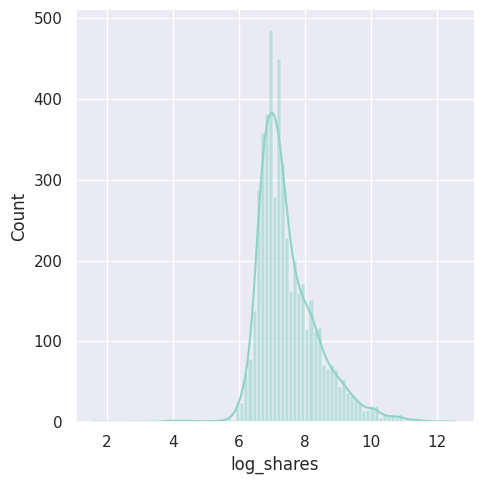

In [38]:
df["log_shares"] = np.log(df['shares'])
sns.displot(df["log_shares"], kde=True)
plt.show()

In [39]:
y = df['log_shares']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=4)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('MAE:', mean_absolute_error(y_valid, y_pred))
print('MedAE:', median_absolute_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

print(f"det (X^T*X): {np.linalg.det(np.linalg.inv(np.dot(X_train.T, X_train) ))}")


MSE: 0.8075672442641555
MAE: 0.6435967448162858
MedAE: 0.47639867052734264
R2: 0.07425972193022479
det (X^T*X): -4.78614394435179e-198


Have better results.But we have close to singular our $XX^T$ matrix Let's try to scale our features

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_st = scaler.fit_transform(X)


X_train_st, X_valid_st, y_train, y_valid = train_test_split(X_st, y, test_size=0.25, random_state=4)
lin_reg_st = LinearRegression()
lin_reg_st.fit(X_train_st, y_train)
y_pred = lin_reg_st.predict(X_valid_st)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))
print(f"det (X^T*X): {np.linalg.det(np.linalg.inv(np.dot(X_train_st.T, X_train_st) ))}")

MSE: 0.8069071848249252
R2: 0.07501636927217148
det (X^T*X): 2.1404342901247636e-137


In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores_reg_st_RMSE = cross_val_score(lin_reg_st, X, y, cv=kf, scoring='neg_root_mean_squared_error')
scores_reg_st_r2 = cross_val_score(lin_reg_st, X_st, y, cv=kf, scoring='r2')

print('array of RMSE score :\n', scores_reg_st_RMSE,"\nmean: ", np.mean(scores_reg_st_RMSE))
print('array of r2 score:\n', scores_reg_st_r2,"\nmean:", np.mean(scores_reg_st_r2))

array of RMSE score :
 [-8.38717255e-01 -8.26966761e-01 -9.12574329e-01 -8.51269503e-01
 -2.35338766e+05] 
mean:  -47068.439105107405
array of r2 score:
 [ 1.26149700e-01  1.20881896e-01  1.36427688e-01  1.31627079e-01
 -6.35007082e+10] 
mean: -12700141645.637201


In crossvalidation we have wery bad model. So we should use regularization

### Ridge

In [42]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
ridge_reg = Ridge()
ridge_reg.fit(X_train_st, y_train)

y_pred = ridge_reg.predict(X_valid_st)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.8057555052228325
R2: 0.07633657660185345


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, scoring='r2', cv=5, log_scale=True):
    # Get training and validation scores
    train_scores, valid_scores = validation_curve(
        estimator, X, y,
        param_name=param_name, param_range=param_range,
        scoring=scoring, cv=cv
    )

    # Calculate mean and standard deviation for training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    plt.plot(param_range, valid_mean, label='Cross-validation score', color='red', marker='o')
    plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='red')

    plt.title(f'Validation Curve for {param_name} in {estimator.__class__.__name__}')
    plt.xlabel(param_name)
    plt.ylabel(f'{scoring.capitalize()} Score')
    
    if log_scale:
        plt.xscale('log')  # Log scale for better visualization if the parameter varies widely
    
    plt.legend()
    plt.show()

Best Parameters: {'alpha': 100.0}
Best R^2 Score: 0.13513121645233925


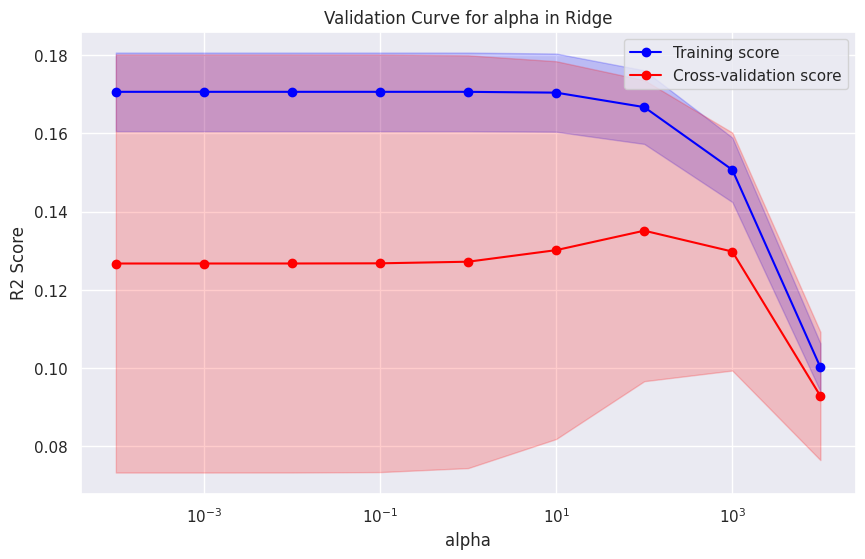

In [44]:
ridge_reg = Ridge()
ridge_params = {'alpha': np.logspace(-4, 4, 9)}
ridge_grid = GridSearchCV(ridge_reg, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train_st, y_train)
print("Best Parameters:", ridge_grid.best_params_)
print("Best R^2 Score:", ridge_grid.best_score_)

plot_validation_curve(ridge_grid.best_estimator_, X_train_st, y_train, 'alpha', np.logspace(-4, 4, 9))

In [45]:
best_ridge = ridge_grid.best_estimator_

y_pred = best_ridge.predict(X_valid_st)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.8031671810466232
R2: 0.07930365576416154


### Lasso

In [46]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

y_pred = lasso_reg.predict(X_valid)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.8277800556046484
R2: 0.05108912688216827


Best Parameters: {'alpha': 0.01}
Best R^2 Score: 0.13779654853204137


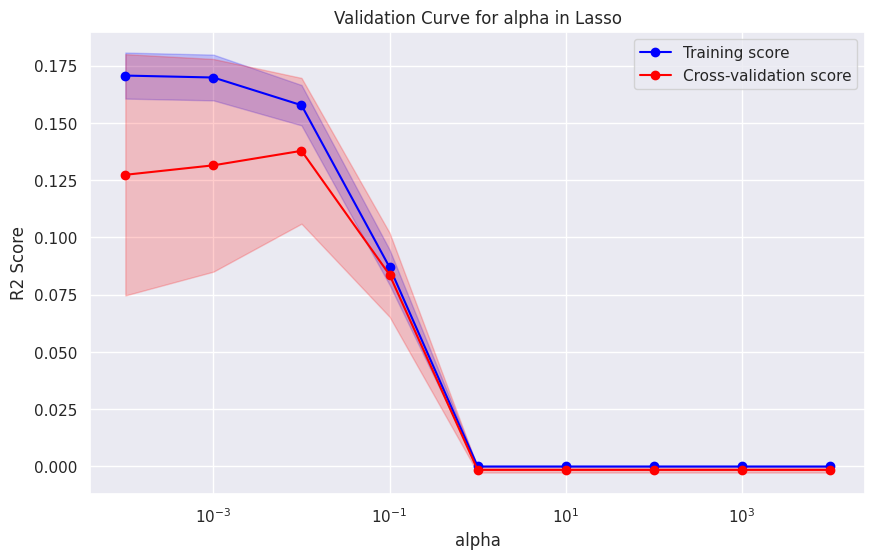

In [47]:
lasso_reg = Lasso(max_iter=10000)  # Increase the max_iter value
lasso_params = {'alpha': np.logspace(-4, 4, 9)}
lasso_grid = GridSearchCV(lasso_reg, lasso_params, cv=5, scoring='r2')
lasso_grid.fit(X_train_st, y_train)
print("Best Parameters:", lasso_grid.best_params_)
print("Best R^2 Score:", lasso_grid.best_score_)

plot_validation_curve(lasso_grid.best_estimator_, X_train_st, y_train, 'alpha', np.logspace(-4, 4, 9))

In [48]:
best_lasso = lasso_grid.best_estimator_

y_pred = best_lasso.predict(X_valid_st)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.7915079283133534
R2: 0.09266903176726793


### Elastic net

In [49]:

elasticNet_reg = ElasticNet()
elasticNet_reg.fit(X_train_st, y_train)

y_pred = elasticNet_reg.predict(X_valid_st)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.8723595835765379
R2: -1.3818307888380232e-05


Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.8}
Best R^2 Score: 0.13799305618733151


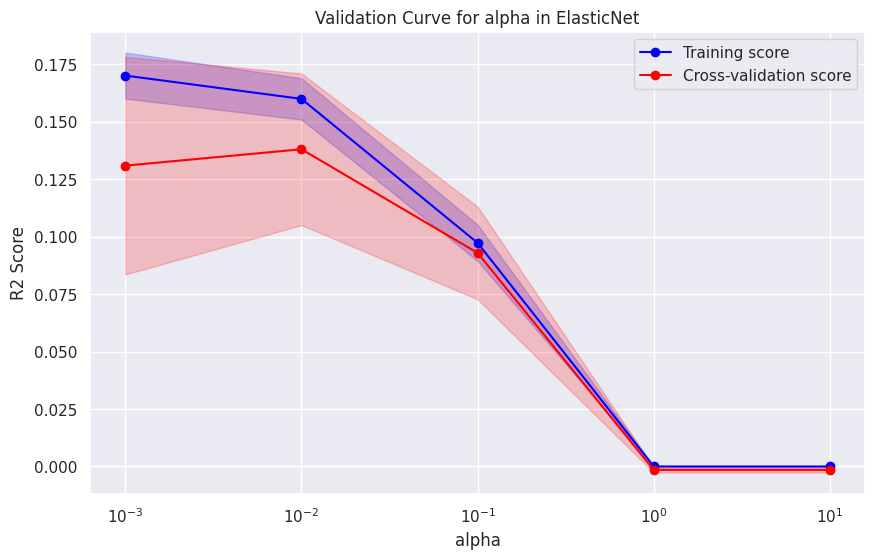

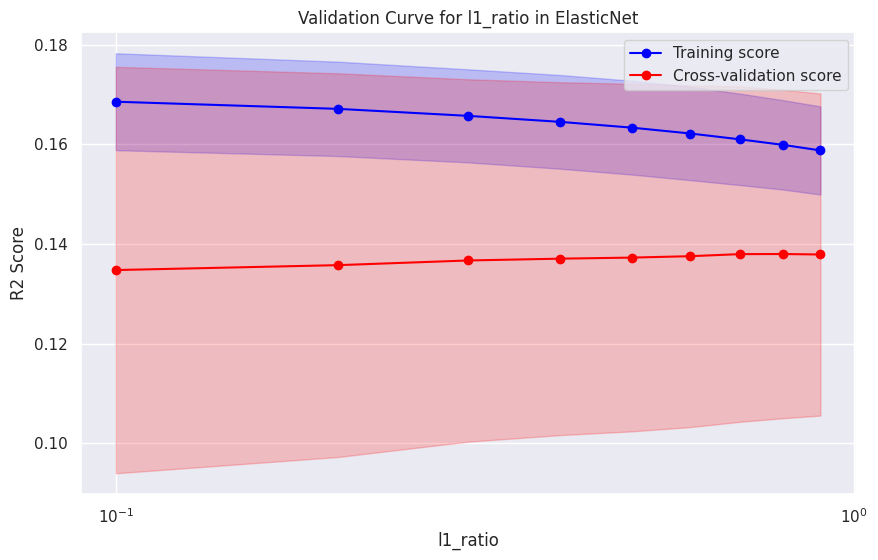

In [50]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the ElasticNet model
elasticNet_reg = ElasticNet(max_iter=15000)

# Define the parameter grid to search
param_grid = {
    'alpha': np.logspace(-2, 4, 9),
    'l1_ratio': np.linspace(0.1, 0.9, 9)
}

# Create the GridSearchCV object
elasticNet_grid = GridSearchCV(elasticNet_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
elasticNet_grid.fit(X_train_st, y_train)

# Print the best parameters and best score
print("Best Parameters:", elasticNet_grid.best_params_)
print("Best R^2 Score:", elasticNet_grid.best_score_)

# Visualize the results using your plot_validation_curve function
plot_validation_curve(elasticNet_grid.best_estimator_, X_train_st, y_train, 'alpha', [0.001, 0.01, 0.1, 1.0, 10.0])
plot_validation_curve(elasticNet_grid.best_estimator_, X_train_st, y_train, 'l1_ratio', np.linspace(0.1, 0.9, 9))

In [51]:
best_elastic = elasticNet_grid.best_estimator_

y_pred = best_elastic.predict(X_valid_st)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))

MSE: 0.7939921591276384
R2: 0.0898212781701031


Best r2 score for test value show Lasso linear model (0.09266903176726793). Best results in GridSearch show ElasticNet (0.13799305618733151)

## Linear regression coefficients

For LinearRegression model 

In [52]:
feature_names = X_train.columns
coefficients = lin_reg_st.coef_
feature_coefficients = list(zip(feature_names, coefficients))

sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

for feature, coefficient in sorted_feature_coefficients:
    print(f"{feature}: {coefficient:.4f}")

weekday_is_tuesday: -134289203238.4417
weekday_is_wednesday: -130535360408.5744
weekday_is_monday: -129567461073.3880
weekday_is_thursday: -127099077483.9260
weekday_is_friday: -117997211994.3895
is_weekend: -49466961708.3100
weekday_is_sunday: -49186986739.2087
weekday_is_saturday: -47019688497.1947
LDA_03: -4858461.4276
LDA_02: -4804250.7717
LDA_04: -3996006.8399
LDA_00: -3678438.2375
LDA_01: -3387616.4331
kw_avg_avg: 0.4206
average_token_length: -0.2367
n_non_stop_unique_tokens: -0.2198
kw_max_avg: -0.2127
n_unique_tokens: 0.1918
rate_positive_words: 0.1317
data_channel_is_lifestyle: -0.1116
kw_avg_min: 0.0992
self_reference_avg_sharess: 0.0965
data_channel_is_world: -0.0899
data_channel_is_bus: -0.0813
kw_max_min: -0.0805
data_channel_is_entertainment: -0.0714
num_keywords: 0.0652
kw_min_avg: -0.0646
n_non_stop_words: 0.0625
num_hrefs: 0.0552
max_positive_polarity: 0.0442
global_sentiment_polarity: -0.0379
rate_negative_words: 0.0357
num_imgs: 0.0304
global_subjectivity: 0.0301
num

We can't say anything about this coefficient because they >>1. The reason for this is singularity our $X^TX$ matrix

For ridge linear model

In [53]:
coefficients = best_ridge.coef_
feature_coefficients = list(zip(feature_names, coefficients))

sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

# coefficients_df = pd.DataFrame(sorted_feature_coefficients, columns=['Feature', 'Coefficient'])

for feature, coefficient in sorted_feature_coefficients:
    print(f"{feature}: {coefficient:.4f}")

kw_avg_avg: 0.3035
kw_max_avg: -0.1315
data_channel_is_lifestyle: -0.0969
average_token_length: -0.0860
data_channel_is_world: -0.0769
data_channel_is_entertainment: -0.0744
kw_avg_min: 0.0723
num_keywords: 0.0700
data_channel_is_bus: -0.0669
self_reference_avg_sharess: 0.0660
n_non_stop_unique_tokens: -0.0645
kw_max_min: -0.0565
num_hrefs: 0.0542
n_unique_tokens: 0.0419
LDA_02: -0.0412
is_weekend: 0.0405
LDA_00: 0.0404
num_imgs: 0.0380
max_positive_polarity: 0.0371
rate_positive_words: 0.0367
self_reference_min_shares: 0.0347
LDA_04: 0.0341
global_subjectivity: 0.0322
num_videos: -0.0313
weekday_is_sunday: 0.0303
kw_min_avg: -0.0297
global_sentiment_polarity: -0.0294
weekday_is_wednesday: -0.0280
kw_avg_max: 0.0249
weekday_is_saturday: 0.0248
weekday_is_tuesday: -0.0241
LDA_03: -0.0224
rate_negative_words: -0.0215
kw_min_max: -0.0206
avg_positive_polarity: -0.0204
max_negative_polarity: -0.0203
num_self_hrefs: -0.0185
min_positive_polarity: 0.0177
global_rate_positive_words: 0.0159
da

For lasso linear model

In [54]:
coefficients = best_lasso.coef_
feature_coefficients = list(zip(feature_names, coefficients))

sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

coefficients_df = pd.DataFrame(sorted_feature_coefficients, columns=['Feature', 'Coefficient'])

# for feature, coefficient in sorted_feature_coefficients:
#     print(f"{feature}: {coefficient:.4f}")
coefficients_df.head(20)

,Feature,Coefficient
0,kw_avg_avg,0.280534
1,kw_max_avg,-0.098977
2,LDA_02,-0.072199
3,is_weekend,0.070254
4,num_keywords,0.063413
5,data_channel_is_lifestyle,-0.062728
6,data_channel_is_entertainment,-0.053992
7,self_reference_avg_sharess,0.049995
8,num_hrefs,0.036343
9,num_imgs,0.033830


For ElastickNet model

In [55]:
coefficients = best_elastic.coef_
feature_coefficients = list(zip(feature_names, coefficients))

sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

coefficients_df = pd.DataFrame(sorted_feature_coefficients, columns=['Feature', 'Coefficient'])

# for feature, coefficient in sorted_feature_coefficients:
#     print(f"{feature}: {coefficient:.4f}")
coefficients_df.head(20)

,Feature,Coefficient
0,kw_avg_avg,0.298147
1,kw_max_avg,-0.115871
2,is_weekend,0.072744
3,data_channel_is_lifestyle,-0.068122
4,LDA_02,-0.066341
5,num_keywords,0.062935
6,data_channel_is_entertainment,-0.055672
7,self_reference_avg_sharess,0.055130
8,num_hrefs,0.039154
9,data_channel_is_world,-0.034414


## Conclusions

The greatest influence show "kw_avg_avg", "data_channel_is_lifestyle" , "is_weekend", "data_channel_is_entertainment", because they have the highest coefficient.